# Mode prediction -- multiple steps -- different features

Operator 2

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [80]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

## Processing functions

In [81]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [ ]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))

    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(np.array(pred), color=colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nTraining features: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))
    
    print(acc)
    print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.show()

    return fig


'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.tight_layout()
    plt.show()

    return fig

In [83]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

In [84]:
op2_overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
               'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
               'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

test = read_dataset(dataset, campaigns=[op2_overlap[0]])
train = read_dataset(dataset, campaigns=op2_overlap[1:3])
test_campaigns = test['campaign'].unique().tolist()

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[op2_overlap[3]])
test = pd.concat([route_to_add[5350::], test])
test.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [85]:
target_features = ['Mode']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

## 1 step ahead

In [ ]:
# parameters
n_steps_in = 2
n_steps_out = 1
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.601,0.601,1.000,0.492,0.492,1.000,[0.6006761039509825],[0.4917739628040057]
1,SINR,0.521,0.608,0.572,0.619,0.579,0.821,[0.521445172195225],[0.6189198855507868]
2,RSRQ,0.560,0.595,0.841,0.513,0.502,0.938,[0.5601098668920347],[0.5126967095851216]
3,"RSRP, SINR",0.470,0.575,0.451,0.632,0.598,0.772,[0.4703148109021762],[0.6323319027181689]
4,"RSRP, RSRQ",0.500,0.586,0.572,0.587,0.583,0.565,[0.5003169237270231],[0.5870886981402003]
5,"SINR, RSRQ",0.524,0.595,0.654,0.602,0.563,0.856,[0.5244031269807733],[0.601931330472103]
6,"RSRP, SINR, RSRQ",0.601,0.601,1.000,0.492,0.492,1.000,[0.6006761039509825],[0.4917739628040057]
7,SSS_RSRP,0.683,0.834,0.589,0.733,0.768,0.656,[0.6828649904922882],[0.7333690987124464]
8,SSS_SINR,0.661,0.820,0.558,0.783,0.807,0.735,[0.6608916120853581],[0.7829041487839771]
9,SSS_RSRQ,0.573,0.796,0.389,0.743,0.854,0.576,[0.5734206634270019],[0.7432045779685265]


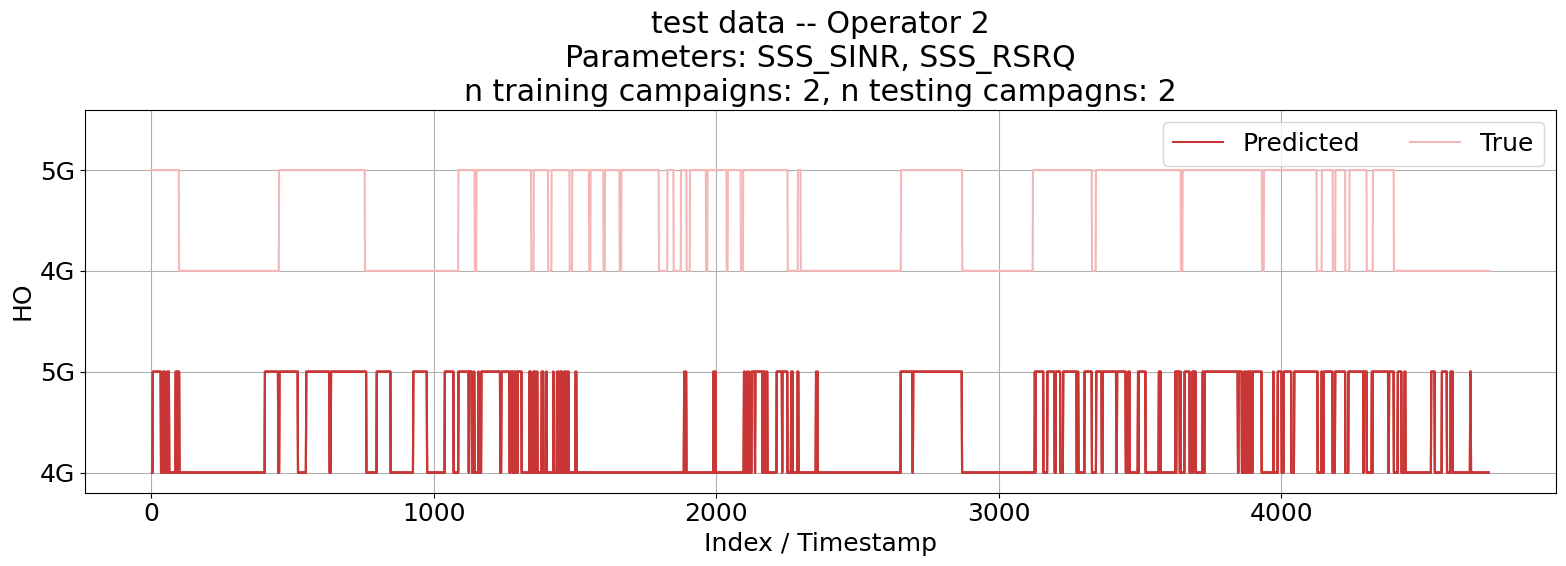

In [87]:

combination = 'SSS_SINR, SSS_RSRQ'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_sss_sinr_rsrq.pdf')

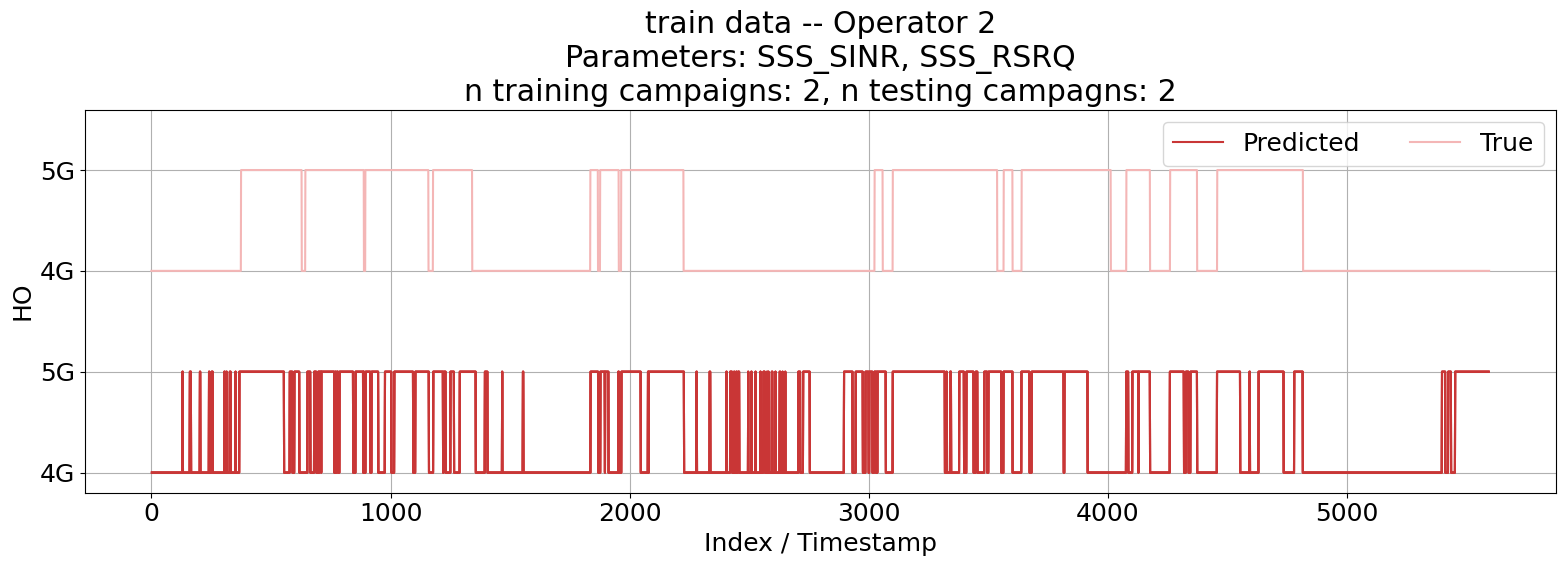

In [88]:
fig = plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_sss_sinr_rsrq_train.pdf')

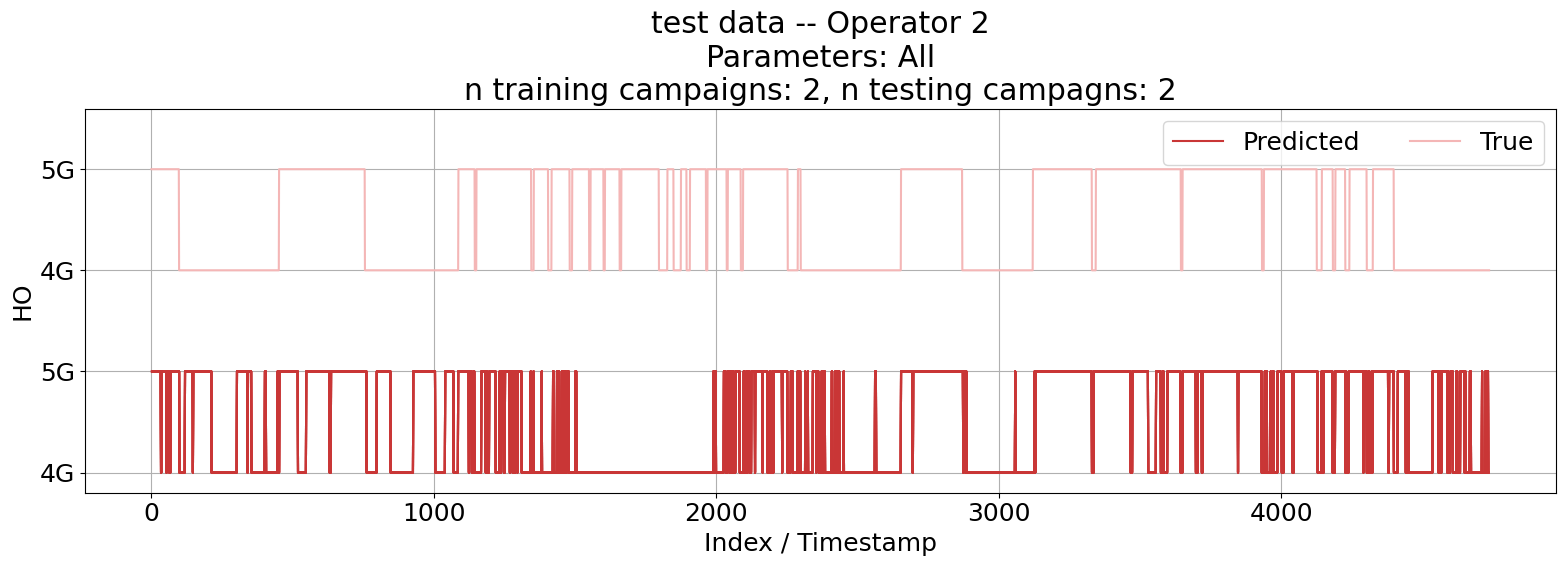

In [89]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_all_param.pdf')

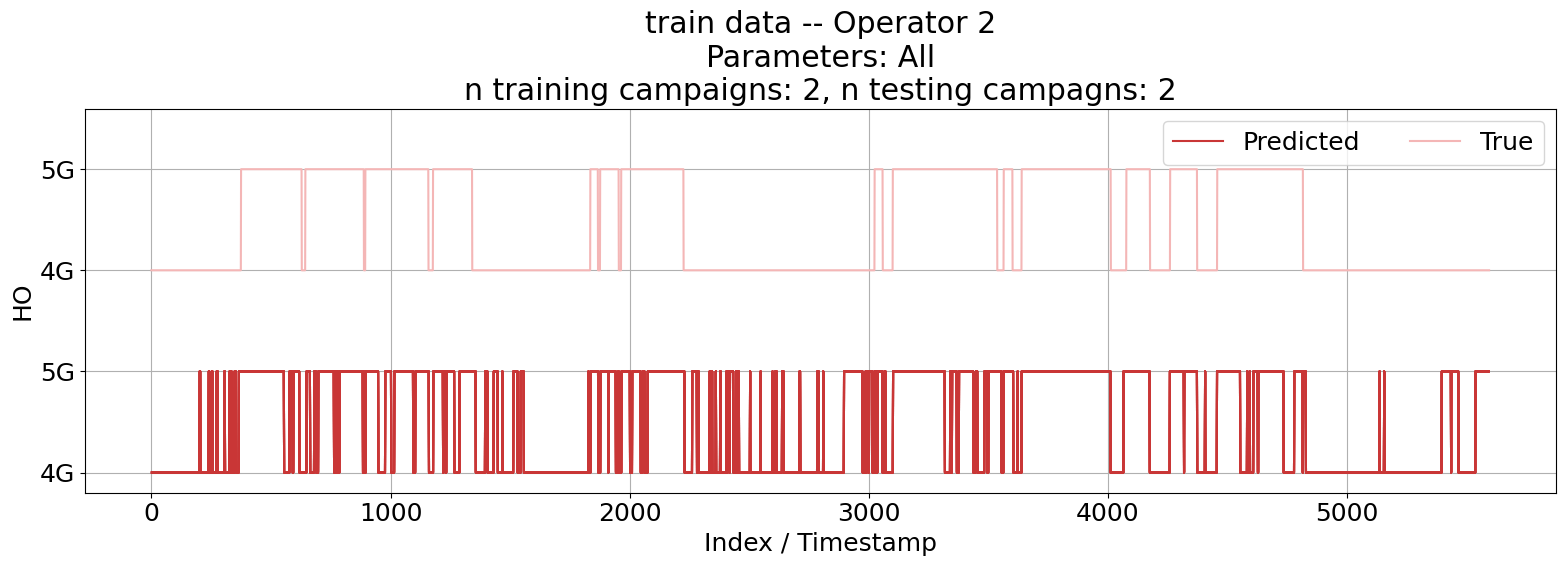

In [90]:
fig = plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_all_param_train.pdf')

## 2 steps ahead

In [ ]:
# parameters
n_steps_in = 2
n_steps_out = 2
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.452,0.990,0.088,0.525,0.846,0.043,"[0.4519129148171634, 0.4519129148171634]","[0.5252236135957066, 0.5255813953488372]"
1,SINR,0.486,0.600,0.429,0.647,0.619,0.731,"[0.4859437751004016, 0.4850982878883957]","[0.646690518783542, 0.6470483005366726]"
2,RSRQ,0.538,0.588,0.773,0.505,0.498,0.863,"[0.533713802578736, 0.5425914183047982]","[0.5076923076923077, 0.5016100178890877]"
3,"RSRP, SINR",0.426,0.546,0.268,0.631,0.673,0.489,"[0.4269710420629888, 0.42528006763897697]","[0.6309481216457961, 0.6320214669051878]"
4,"RSRP, RSRQ",0.503,0.590,0.569,0.632,0.640,0.576,"[0.5043331219615304, 0.502430775734517]","[0.6320214669051878, 0.6318425760286226]"
5,"SINR, RSRQ",0.479,0.576,0.505,0.657,0.611,0.835,"[0.4804481082223631, 0.4779116465863454]","[0.6567084078711986, 0.6572450805008945]"
6,"RSRP, SINR, RSRQ",0.415,0.527,0.257,0.586,0.613,0.430,"[0.41513422109490594, 0.4149228492919045]","[0.587298747763864, 0.5849731663685152]"
7,SSS_RSRP,0.666,0.747,0.670,0.704,0.665,0.803,"[0.6681462692876771, 0.66286197421264]","[0.7050089445438282, 0.7025044722719141]"
8,SSS_SINR,0.645,0.813,0.531,0.797,0.836,0.729,"[0.6467977171845276, 0.6434157683365039]","[0.7998211091234347, 0.7933810375670841]"
9,SSS_RSRQ,0.572,0.830,0.361,0.729,0.891,0.511,"[0.5732403297400127, 0.570281124497992]","[0.7302325581395349, 0.7275491949910554]"


Number of predicted 5G point: 9462
Number of true 5G points: 5684

[0.6009300359332065, 0.6005072923272036]
[0.4919499105545617, 0.4919499105545617]


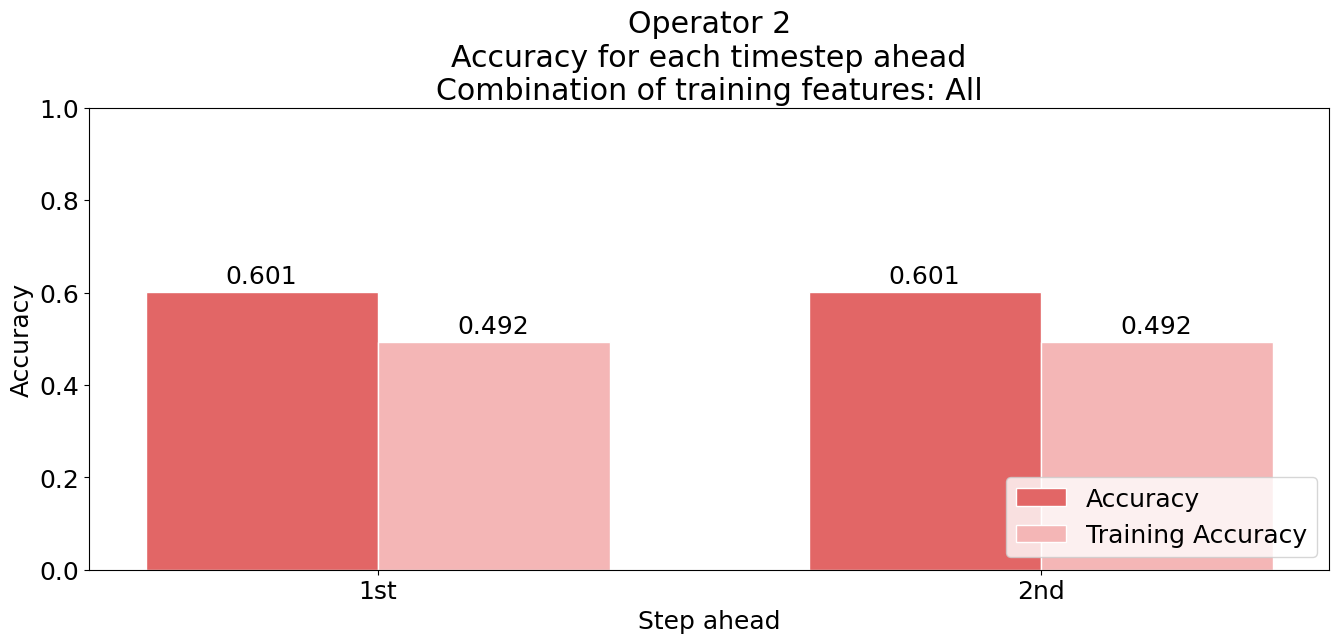

In [92]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_2_steps.pdf')

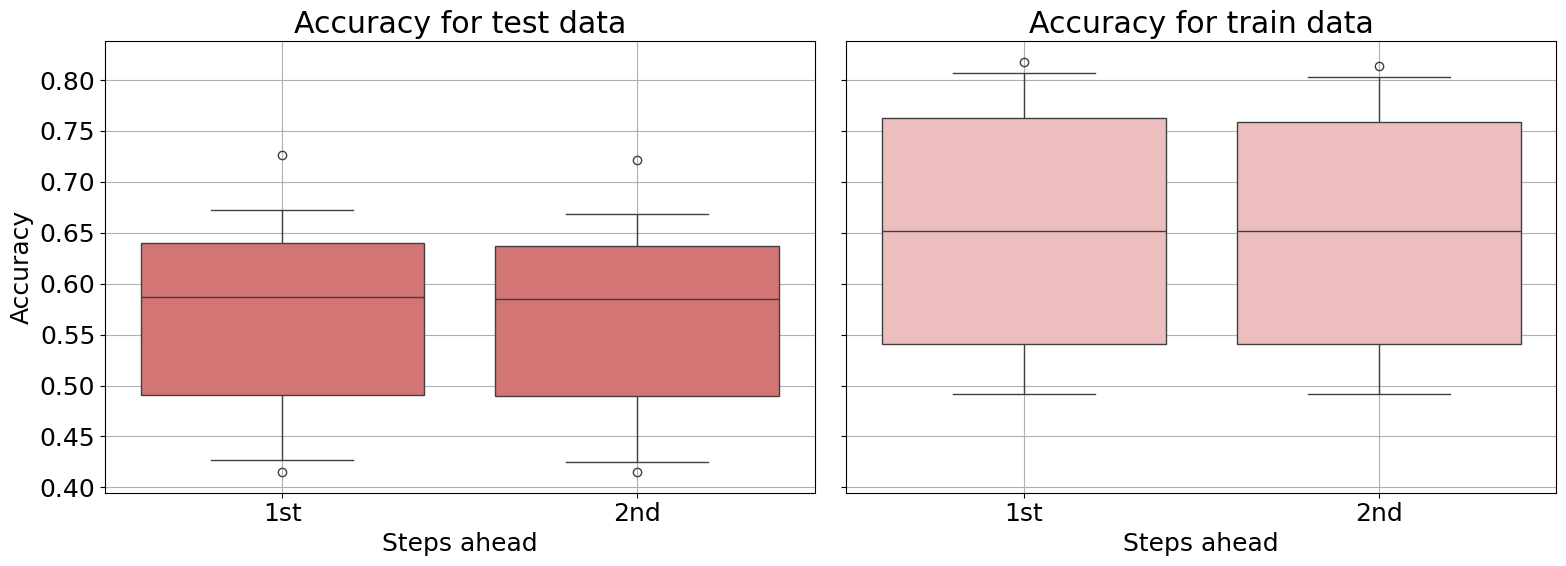

In [93]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_2_steps.pdf')

## 3 steps ahead

In [ ]:
# parameters
n_steps_in = 3
n_steps_out = 3
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.479,0.568,0.552,0.605,0.597,0.608,"[0.48064311402580917, 0.4808546646921938, 0.47...","[0.6081274615109201, 0.6011457214464734, 0.606..."
1,SINR,0.460,0.585,0.346,0.634,0.620,0.664,"[0.46118045271842606, 0.4594880473873493, 0.45...","[0.6335481561045471, 0.63390619405657, 0.63444..."
2,RSRQ,0.563,0.596,0.846,0.515,0.504,0.947,"[0.5665326845779565, 0.5608208165855723, 0.560...","[0.5148585750089509, 0.5148585750089509, 0.514..."
3,"RSRP, SINR",0.535,0.620,0.586,0.631,0.590,0.821,"[0.5354347366194203, 0.5354347366194203, 0.535...","[0.6326530612244898, 0.6274615109201576, 0.633..."
4,"RSRP, RSRQ",0.522,0.592,0.654,0.581,0.564,0.658,"[0.5214723926380368, 0.5214723926380368, 0.521...","[0.583780880773362, 0.5798424633011099, 0.5803..."
5,"SINR, RSRQ",0.493,0.584,0.539,0.708,0.649,0.886,"[0.4937592553416543, 0.49270150200973134, 0.49...","[0.7074829931972789, 0.7078410311493019, 0.708..."
6,"RSRP, SINR, RSRQ",0.530,0.630,0.525,0.653,0.621,0.756,"[0.5309921726253438, 0.5280304632959594, 0.530...","[0.6512710347296814, 0.6512710347296814, 0.655..."
7,SSS_RSRP,0.656,0.724,0.690,0.655,0.609,0.837,"[0.6604611804527184, 0.656441717791411, 0.6509...","[0.6568206229860365, 0.6546723952738991, 0.652..."
8,SSS_SINR,0.659,0.810,0.565,0.782,0.794,0.751,"[0.6640575417812566, 0.6589803257880262, 0.653...","[0.7853562477622628, 0.7817758682420336, 0.778..."
9,SSS_RSRQ,0.590,0.765,0.458,0.734,0.778,0.643,"[0.5942458218743389, 0.5900148085466469, 0.585...","[0.7370211242391693, 0.7337987826709631, 0.730..."


Number of predicted 5G point: 6846
Number of true 5G points: 8517

[0.7063676750581764, 0.7017135603977153, 0.6985403004019463]
[0.8231292517006803, 0.8191908342284282, 0.815610454708199]


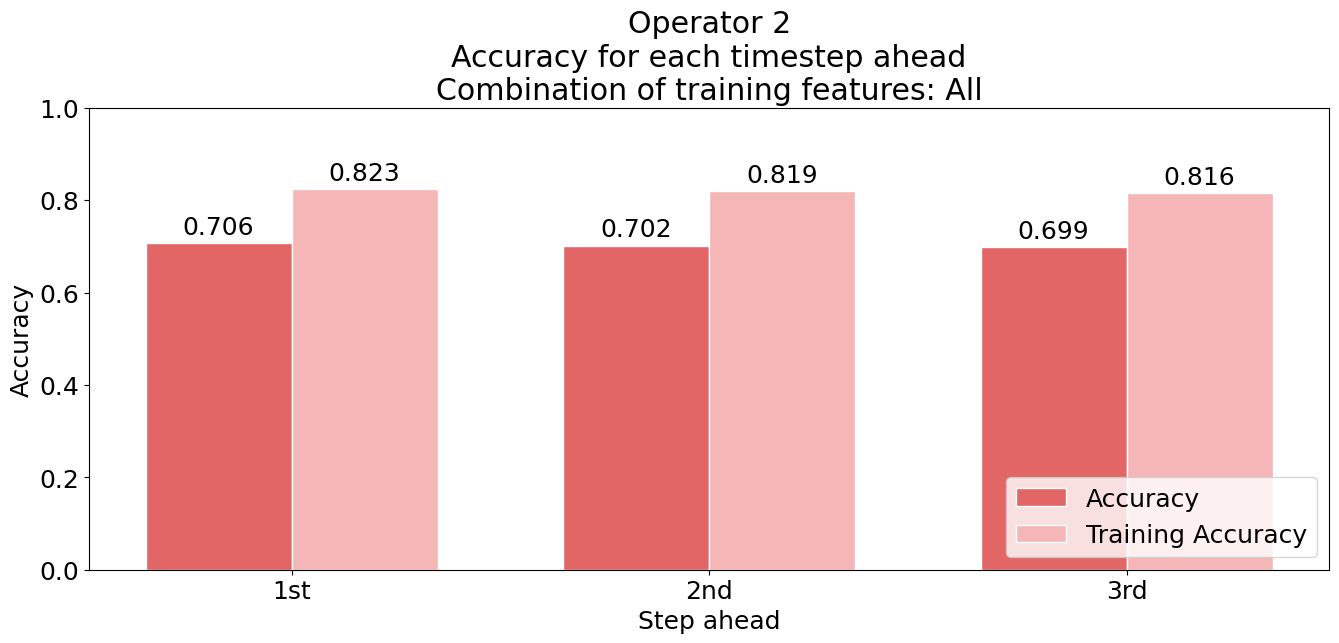

In [95]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_3_steps.pdf')

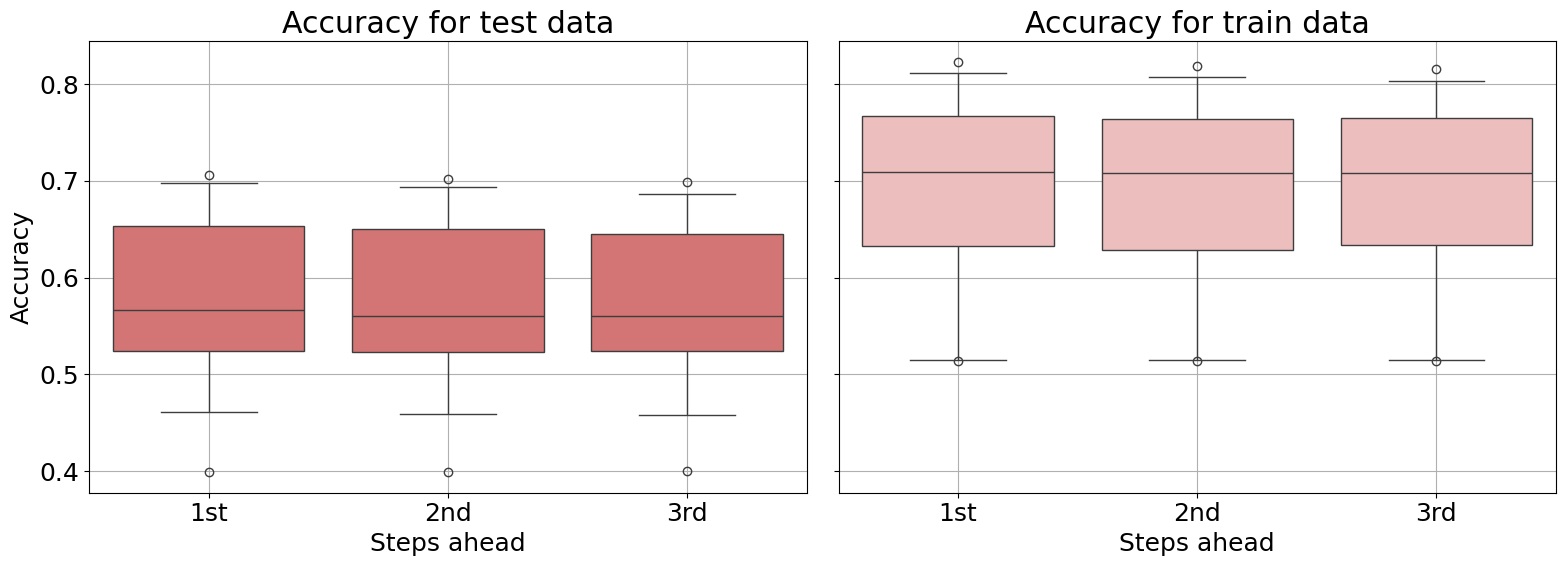

In [96]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_3_steps.pdf')

## 5 steps ahead

In [ ]:
# parameters
n_steps_in = 5
n_steps_out = 5
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.600,0.600,1.000,0.493,0.493,1.000,"[0.601186692095783, 0.6007628734901462, 0.6003...","[0.49300824668339904, 0.49300824668339904, 0.4..."
1,SINR,0.517,0.597,0.600,0.636,0.590,0.859,"[0.5212968849332485, 0.5200254291163382, 0.518...","[0.6360702760846182, 0.6358910003585515, 0.636..."
2,RSRQ,0.564,0.588,0.920,0.513,0.503,0.972,"[0.5660097478279297, 0.5649502013138377, 0.564...","[0.5130871280028684, 0.5129078522768017, 0.512..."
3,"RSRP, SINR",0.514,0.606,0.549,0.610,0.580,0.758,"[0.5151515151515151, 0.5149396058486968, 0.514...","[0.6111509501613481, 0.6075654356400143, 0.608..."
4,"RSRP, RSRQ",0.447,0.970,0.081,0.526,0.872,0.045,"[0.45179063360881544, 0.44543335452426364, 0.4...","[0.5250986016493366, 0.5256364288275368, 0.525..."
5,"SINR, RSRQ",0.523,0.594,0.648,0.664,0.602,0.943,"[0.5223564314473406, 0.5225683407501589, 0.522...","[0.6624238078164216, 0.6633201864467551, 0.663..."
6,"RSRP, SINR, RSRQ",0.600,0.600,1.000,0.496,0.495,1.000,"[0.601186692095783, 0.6007628734901462, 0.6003...","[0.4960559340265328, 0.4960559340265328, 0.496..."
7,SSS_RSRP,0.649,0.724,0.671,0.663,0.621,0.810,"[0.6588260224623861, 0.653952108497563, 0.6490...","[0.6669057009680889, 0.6643958408031553, 0.662..."
8,SSS_SINR,0.648,0.806,0.544,0.787,0.807,0.748,"[0.6564950201313837, 0.6518330154693791, 0.646...","[0.7938329150233059, 0.7907852276801721, 0.788..."
9,SSS_RSRQ,0.591,0.756,0.470,0.724,0.748,0.663,"[0.5982199618563255, 0.5944055944055944, 0.590...","[0.7287558264610972, 0.7262459662961634, 0.723..."


Number of predicted 5G point: 23595
Number of true 5G points: 14165

[0.601186692095783, 0.6007628734901462, 0.6003390548845094, 0.5999152362788727, 0.5994914176732359]
[0.49300824668339904, 0.49300824668339904, 0.49300824668339904, 0.49300824668339904, 0.49300824668339904]


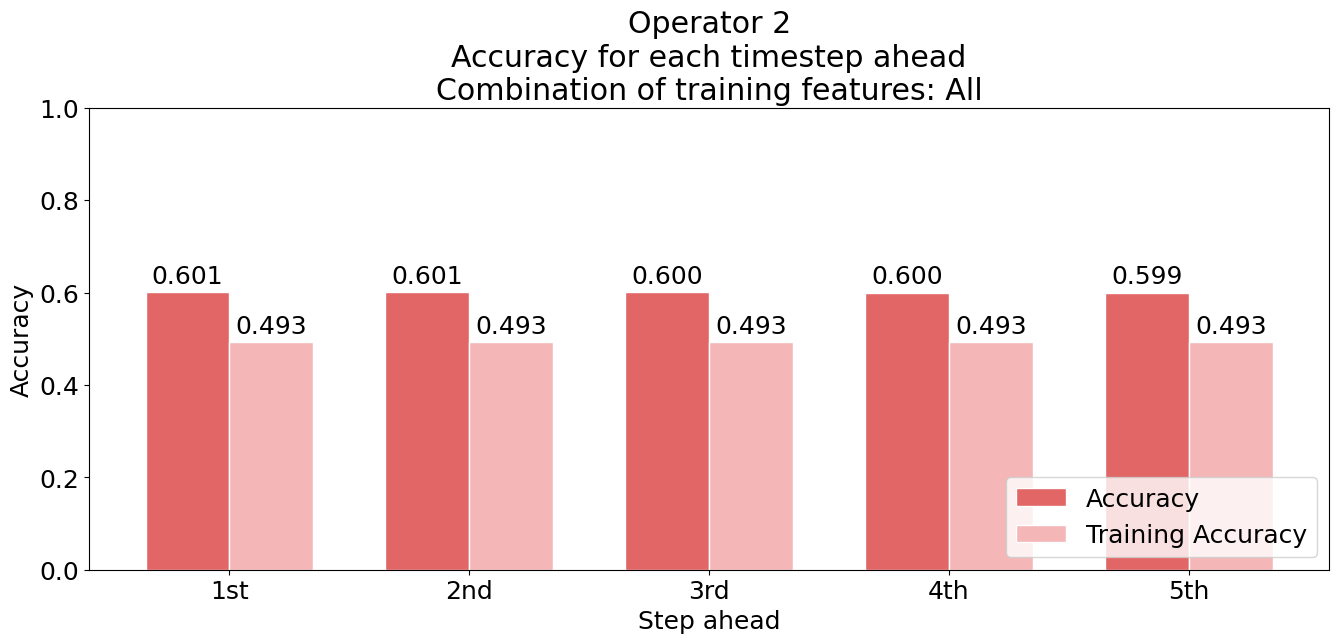

In [98]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_5_steps.pdf')

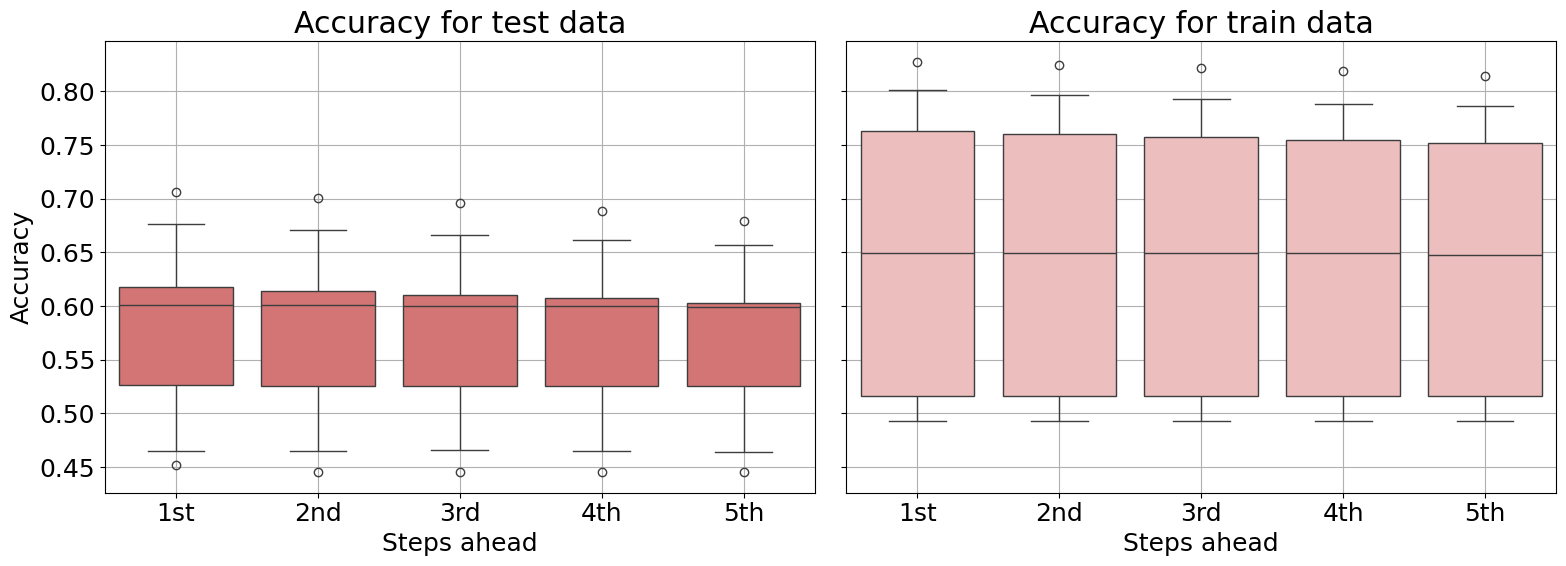

In [99]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_5_steps.pdf')

## 10 steps ahead

In [ ]:
# parameters
n_steps_in = 8
n_steps_out = 10
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.600,0.600,1.000,0.494,0.494,1.000,"[0.60195619817138, 0.6015309376993409, 0.60110...","[0.4944264653002517, 0.4944264653002517, 0.494..."
1,SINR,0.501,0.602,0.498,0.648,0.611,0.791,"[0.509249415266851, 0.5071231129066553, 0.5054...","[0.6479683567062208, 0.6479683567062208, 0.647..."
2,RSRQ,0.591,0.597,0.976,0.517,0.506,0.983,"[0.5900489049542845, 0.5900489049542845, 0.591...","[0.5183387270765911, 0.5185185185185185, 0.518..."
3,"RSRP, SINR",0.428,0.537,0.331,0.669,0.668,0.657,"[0.4273867743993196, 0.42696151392728043, 0.42...","[0.6661272923408845, 0.6672060409924487, 0.668..."
4,"RSRP, RSRQ",0.530,0.616,0.575,0.605,0.590,0.660,"[0.5271103550924942, 0.5375292366574527, 0.522...","[0.6039194534340165, 0.6082344480402733, 0.607..."
5,"SINR, RSRQ",0.489,0.579,0.548,0.720,0.652,0.931,"[0.4926642568573251, 0.4909632149691686, 0.489...","[0.7166486875224739, 0.7191657677094571, 0.720..."
6,"RSRP, SINR, RSRQ",0.595,0.598,0.991,0.496,0.495,0.986,"[0.5968530725069104, 0.5964278120348714, 0.596...","[0.49658396260338006, 0.4962243797195254, 0.49..."
7,SSS_RSRP,0.646,0.740,0.633,0.703,0.674,0.776,"[0.665532638741229, 0.6608547735487986, 0.6557...","[0.7159295217547644, 0.705861201006832, 0.7108..."
8,SSS_SINR,0.654,0.804,0.560,0.791,0.808,0.758,"[0.6727620667658941, 0.6685094620455029, 0.667...","[0.8130169003955412, 0.8097806544408486, 0.802..."
9,SSS_RSRQ,0.562,0.783,0.373,0.731,0.863,0.541,"[0.5772910907931108, 0.5734637465447586, 0.570...","[0.7400215749730313, 0.7371449119021934, 0.734..."


Number of predicted 5G point: 23354
Number of true 5G points: 28220

[0.6904103763555177, 0.6861577716351265, 0.681054645970657, 0.6763767807782267, 0.6727620667658941, 0.6695726132256007, 0.6678715713374442, 0.6644694875611312, 0.6570274293004466, 0.6478843291516053]
[0.8194893923049262, 0.8166127292340885, 0.8135562747213233, 0.807982740021575, 0.8054656598345918, 0.8027687882056814, 0.8000719165767709, 0.7970154620640058, 0.7955771305285868, 0.7923408845738943]


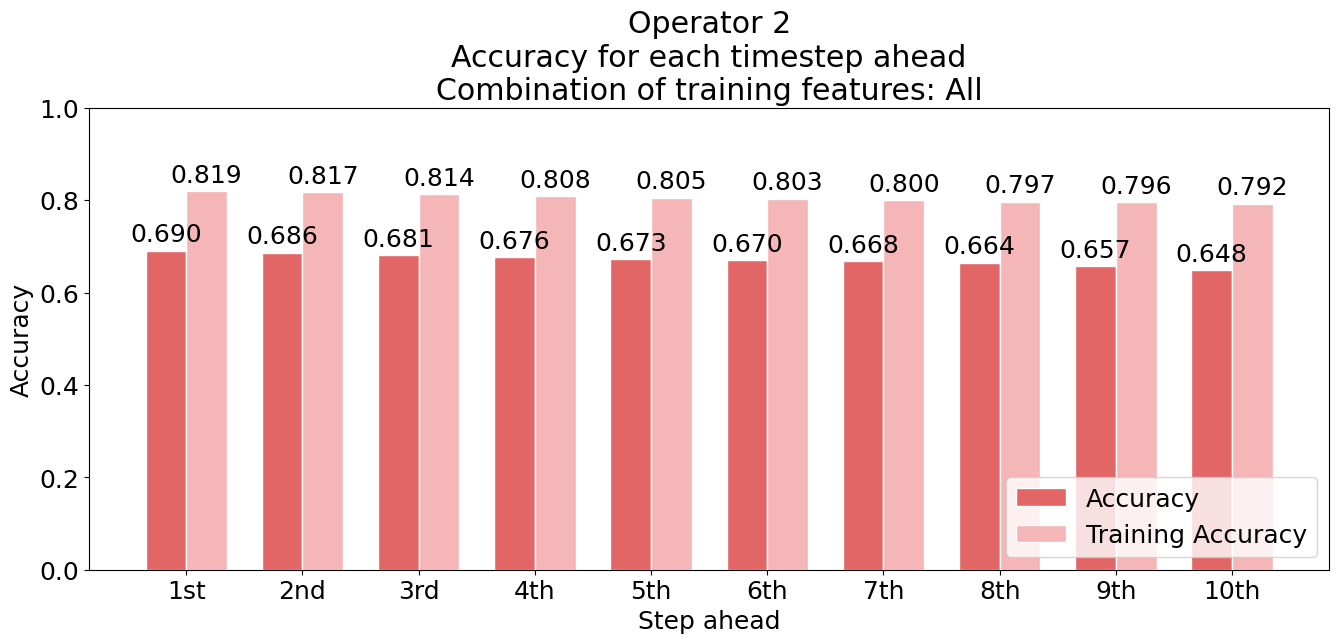

In [101]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_10_steps.pdf')

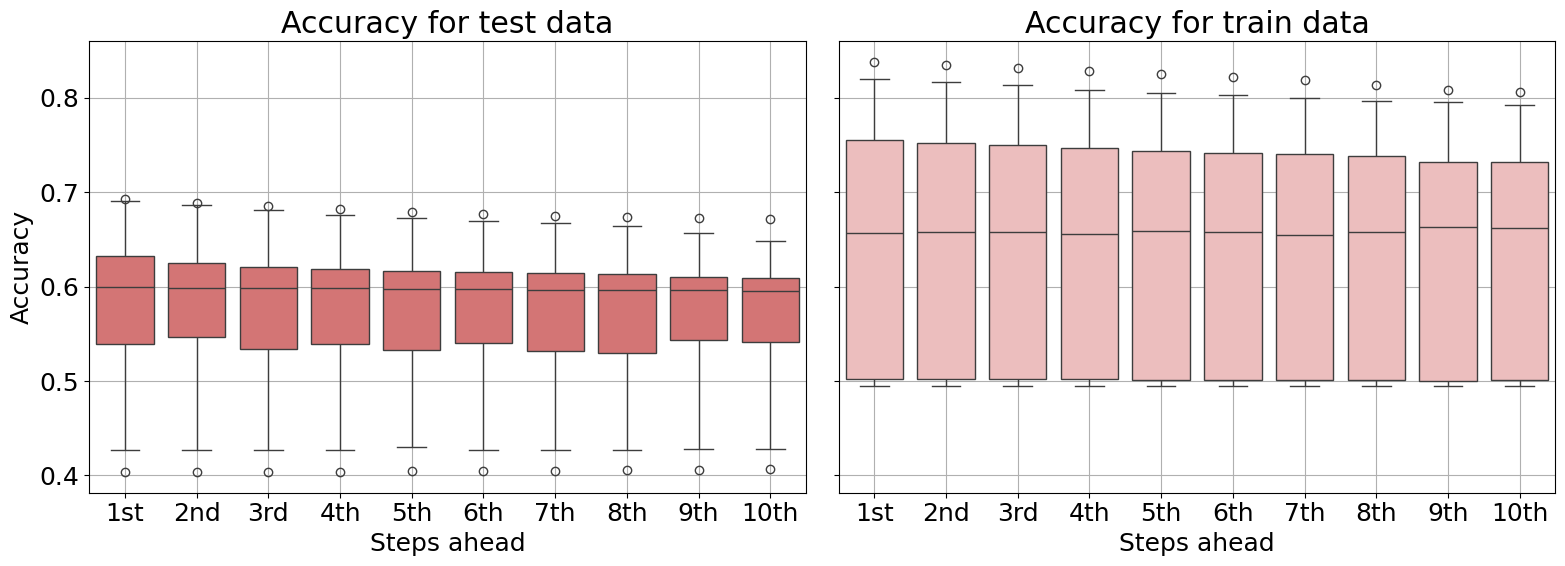

In [102]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_10_steps.pdf')